## Pair sampling
MS2DeepScore is trained by many pairs of spectra. For each spectrum an embedding is generated, the cosine score between the embeddings is computed and the loss is calculated based on the difference between the predicted similarity and the true tanimoto score. For MS2DeepScore we want to have a method that is both good at predicting low similarity but also at predicting high similarity. If we would just sample random pairs of spectra the problem is that we would almost always have low similarity scores, since most molecules have low similarity. This would result in a model that mostly predicts low scores. To overcome this issue we actively select spectrum pairs to have a better distribution of scores. 

### Show distribution of tanimoto scores
The code below computes tanimoto scores for the validation set and plots the distribution, showing that most scores are low. 

In [1]:
import requests
import os
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))  # Update progress bar by the chunk size
    
spectrum_file_name = "validation_spectra.mgf"
download_file("https://zenodo.org/records/13934470/files/positive_validation_spectra.mgf?download=1", spectrum_file_name)


The file validation_spectra.mgf already exists, the file won't be downloaded


In [2]:
from matchms.importing.load_spectra import load_spectra
from tqdm import tqdm
# load in spectra
spectra = list(tqdm(load_spectra(spectrum_file_name)))

25412it [00:23, 1095.42it/s]


In [3]:
from ms2deepscore.validation_loss_calculation.calculate_scores_for_validation import calculate_tanimoto_scores_unique_inchikey

In [4]:
tanimoto_scores = calculate_tanimoto_scores_unique_inchikey(spectra, spectra)

Calculating fingerprints: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [00:06<00:00, 269.27it/s]


Calculating tanimoto scores


In [5]:
tanimoto_scores.mean().mean()

0.22762467

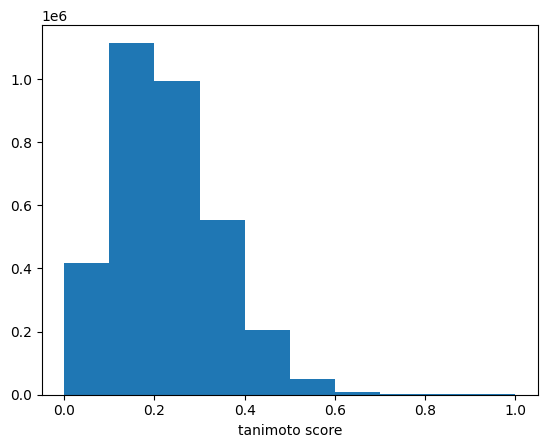

In [6]:
from matplotlib import pyplot as plt
plt.hist(tanimoto_scores.to_numpy().ravel())
plt.xlabel("tanimoto score")
plt.show()

# Sampling pairs per bin
Our solution is to sample pairs per bin. The default is 10 bins between 0 and 1, but this can be changed in the settings. Below we do this sampling. 

In [8]:
from ms2deepscore.train_new_model.inchikey_pair_selection import create_spectrum_pair_generator
from ms2deepscore import SettingsMS2Deepscore
spectrum_pair_generator = create_spectrum_pair_generator(spectra, SettingsMS2Deepscore())

Selected 1831 spectra with unique inchikeys for calculating tanimoto scores (out of 25412 spectra)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.29it/s]


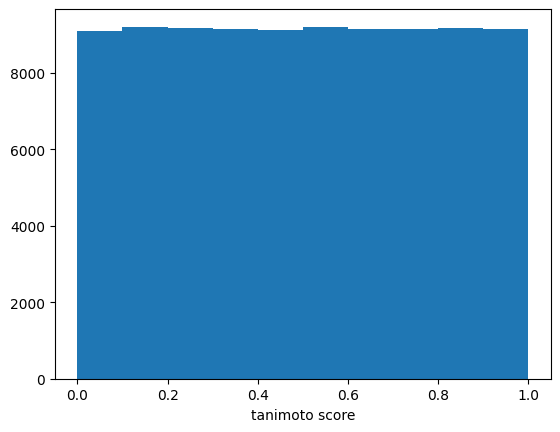

In [10]:
plt.hist(spectrum_pair_generator.get_scores())
plt.xlabel("tanimoto score")
plt.show()

# Balanced sampling per bin
Simply sampling equally from each bin would result in unwanted biases. Not each compound has an equal distribution of scores, some have many highly similar compounds in the training data and some have barely any. If we would randomly sample from each bin, this information would be contained, thereby potentially training the model to learn the distribution of the training data, which is not wanted. We optimized the sampling algorithm for three things at the same time:
1. Sampling each bin equally
2. Sampling each inchikey a similar amount
3. For each inchikey sample from each bin equally.

This was quite challenging to get to work. More details about the settings optimization can be found in the supplementary Note 1, where we did a lot of optimization for the settings. 

# Important! The sampling algorithm was optimized specifically for one specific training set.
If you want to use a different training set you need to reoptimize the settings. Particularly if you have a small training set, it is difficult or just impossible to get this to work well. For small training sets with for instance 2000 unique inchikeys there are just not enough options to pick for the high tanimoto scores, to achieve all three goals above. For the training set that we used to train 36000 unique inchikeys MS2DeepScore we did achieve all three goals to a good level. If you use a different training set, with diffirent score distributions, this might also be needed to be set up again. 

Below we show an example of a badly distributed scores (because we only use the validation spectra, which contain 1800 unique molecules). 

The function below generates 6 diagnostic plots that tells you something about how well the pair sampling works for your training set.

In [11]:
import numpy as np
from collections import Counter
def plot_diagnostic_plots(pair_generator, title):
    fig, axes = plt.subplots(3, 2, figsize=(10, 8))
    
    fig.suptitle(title)
    inchikey_frequencies = pair_generator.get_inchikey_counts().values()
    axes[0,0].hist(inchikey_frequencies, bins=range(min(inchikey_frequencies), max(inchikey_frequencies)))
    axes[0,0].set_xlabel("Sample frequency")
    axes[0,0].set_ylabel("Nr of inchikeys")
    
    # Plot average tanimoto score per inchikey 
    scores_per_inchikey = pair_generator.get_scores_per_inchikey().values()
    inchikey_average_sampling = [sum(scores)/len(scores) for scores in scores_per_inchikey]
    axes[0,1].hist(inchikey_average_sampling, bins=[i/100 for i in range(101)])
    axes[0,1].set_xlabel("Average tanimoto score per inchikey")
    axes[0,1].set_ylabel("Nr of inchikeys")
    # axes[0,1].set_ylim((0,8000))

    # Plot highest oversampling
    max_count_per_bin = []
    most_sampled_bins = []
    for scores in scores_per_inchikey:
        counts, _ = np.histogram(scores, bins=[i/10 for i in range(11)])
        most_sampled_bins.append(np.argmax(counts))
        max_count_per_bin.append(max(counts)/len(scores))
        
    axes[1,0].hist(max_count_per_bin, bins=21)
    axes[1,0].set_xlabel("Fraction of pairs in a single bin")
    axes[1,0].set_ylabel("Nr of inchikey")

    axes[1,1].hist(most_sampled_bins, bins=range(11))
    axes[1,1].set_xlabel("Most sampled bin")
    axes[1,1].set_ylabel("Nr of inchikey")


    # Plot oversampling rate per pair
    oversampling_rates = Counter(pair_generator.selected_inchikey_pairs).values()
    axes[2,0].hist(oversampling_rates, bins = range(min(oversampling_rates), max(oversampling_rates)), log =True)
    axes[2,0].set_xlabel("Oversampling rate")
    axes[2,0].set_ylabel("Nr of pairs")

    # Plot total oversampling rate
    total_pairs = len(pair_generator.selected_inchikey_pairs)
    unique_pairs = len(set(pair_generator.selected_inchikey_pairs))
    axes[2,1].bar(["total pairs", "unique pairs"], [total_pairs, unique_pairs])
    axes[2,1].set_xlabel("Oversampling rate")
    axes[2,1].set_ylabel("Nr of pairs")
    plt.tight_layout()
    plt.show()

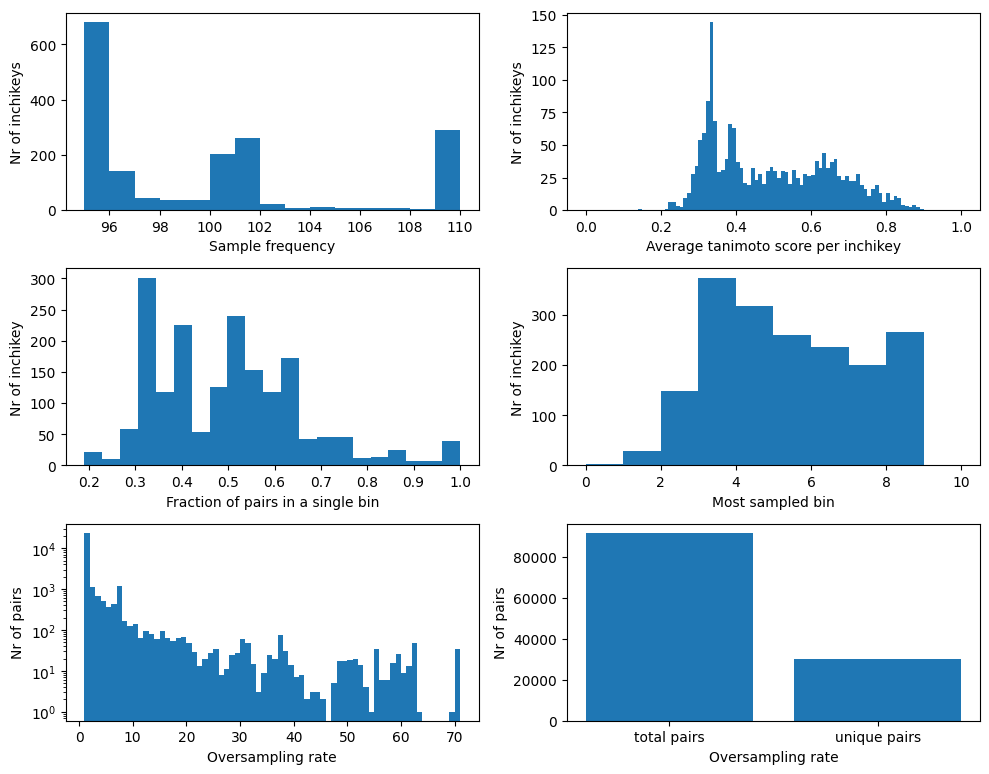

In [12]:
plot_diagnostic_plots(spectrum_pair_generator, "")

# How to interpret the diagnositcs plots
Left-top: The sampling frequency of each inchikey, this is the frequency that each inchikey is sampled. You want this somewhat balanced, to make sure you use the full potential. 

right-top: The average tanimoto score per inchikey. You want this to be close to 0.5. If this is not the case this means that for some inchikeys you are mostly sampling high similarity pairs or low similarity pairs. The risk is that the models learns the distribution of scores in your training set which is bad for generalization. 

left-middle: The fraction of pairs in a single bin. The distribution of tanimoto scores per inchikey is never perfect. So one bin will always be oversampled a bit. But you want this as low as possible. You can have a perfect average of 0.5 (right-top) plot, but just half in the 0-0.1 and the other half in the 0.9-1.0 bin. This plot shows the fraction of pairs in the bin with the most pairs per inchikey. You want this as low as possible. 

right-middle: This is the most sampled bin. This is not super important, but it can help to optimize the bin order, if one bin is very often oversampled you can change the order in which the bins are filled.

left-bottom: The oversampling rate. Some pairs are sampled multiple times. The exact same pair is sampled multiple times. This is required to make it possible to get a good distribution. However, it should not be too high. You don't want a too large fraction that is heavily oversampled, since this doesn't use the diversity of your training set well. 

Right-bottom: The total pairs and the unique pairs. Since resampling/oversampling is allowed we can have pairs that are not unique to balance the sampling more. This graph shows the nubmer of unique pairs and total pairs. You don't want most pairs to be resampled.



# So is the current pair sampling good?
No! We used the small validation set, to deliberately show what a bad distribution looks like. (Good diagnostics plots can be found in the notebook model_benchmarking/optimize_sampling_algorithm_settings) These plots indicate the following issues:

The distribution per unique inchikey is bad. The right-top plot shows that many inchikeys have an average tanimoto score far from the average 0.5. This indicates that for many inchikeys most pairs are sampled with or very high or very low tanimoto scores. 



# So what now? 
There are some options to tweak the sampling algorithm. Below we show such a change in settings (even though it does not solve it). How we chose the ideal settings for training set can be found in model_benchmarking/optimize_sampling_algorithm_settings. However, for the current training set used, I don't think you can find any setting that achieves acceptable results, since the dataset is simply too small. There are therefore too little high similarity options to choose from to achieve a well balanced sampling. So the best option now is to increase the number of unique compounds in your training set. 

Selected 1831 spectra with unique inchikeys for calculating tanimoto scores (out of 25412 spectra)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.57it/s]


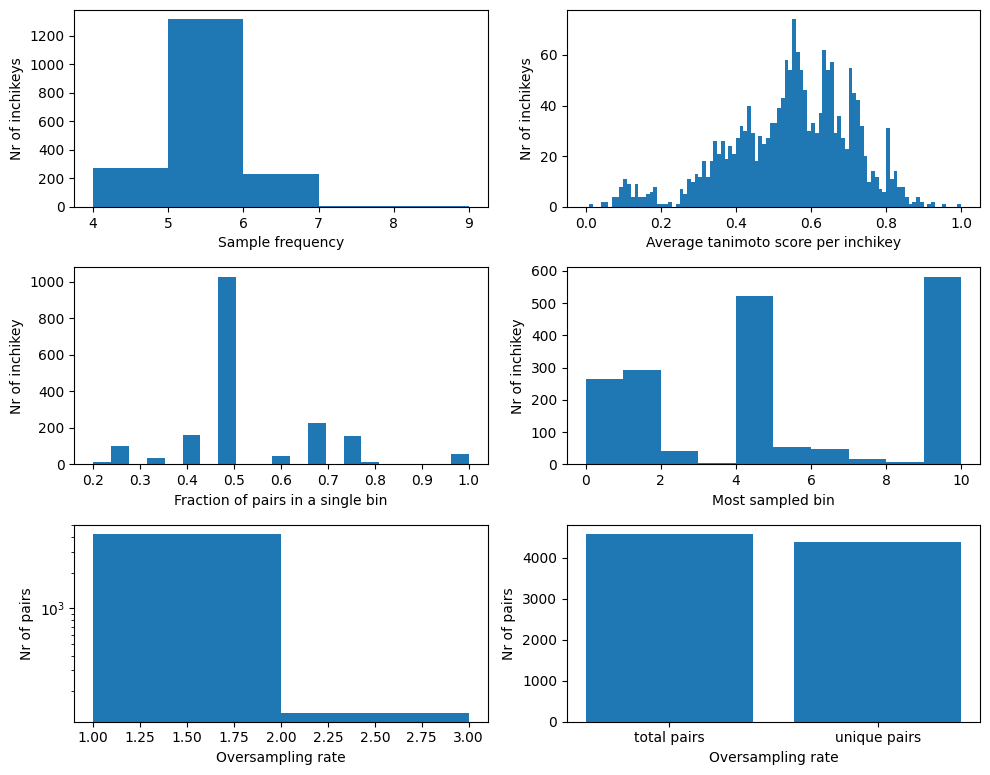

In [13]:
spectrum_pair_generator_new = create_spectrum_pair_generator(spectra, SettingsMS2Deepscore(
    average_inchikey_sampling_count=5, max_inchikey_sampling=100, 
    same_prob_bins = np.array([(0.7, 1.0), (0.4, 0.7), (-0.001, 0.4)])))
plot_diagnostic_plots(spectrum_pair_generator_new, "")

# Cross ionmode pair selection
Since version 2.7.0 there is a cross ionmode pair selection. Which is automatically used when you train on both ionmodes. This creates separate inchikey pairs per ionmodes. To make sure both modes are sampled equally. This was not used for the model in the paper. Some initial tests were performed, which can be found in "model_benchmarking/Compare balanced cross ion mode sampling.ipynb". The results were not yet very convincing, neg-neg becomes better, but pos-pos became worse. It is probably best to further optimize this first before using for model generation. 